# Machine Learning Exam 2024 @ EASV
The following is the Machine Learning mini-project as part of the exam for the Machine Learning course at EASV, part of the PBSW Soring 2024 2nd semester.

The project is on the first part of the course, Fundamental ML model architectures, and will be undertaking Image Classifications tasks on colored images. The specific dataset the model will be trained on is the [Malaria Cell Images Dataset on Kaggle](https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria). This specific dataset was chosen due to being closer to a real-world scenario. The bio-tech industry use Machine Learning themselves to help in reading biopsies and samples.


## Common Imports

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import tensorflow as tf
import keras
from  tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import warnings
import kagglehub
from dotenv import load_dotenv
warnings.filterwarnings("ignore")

# Ensure TF version 2.x
print(tf.__version__)

# Stabilize output across runs by setting seed values
np.random.seed(69)
tf.random.set_seed(69)


# Load environment variables from .env file
load_dotenv()

os.environ["KAGGLE_USERNAME"] = os.getenv("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = os.getenv("KAGGLE_KEY")


2.17.0


## Load the data from Kaggle

In [2]:
# Dataset

# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

print(os.listdir(path))

cell_images_path = os.path.join(path, "cell_images")
print("Contents of cell_images folder:", os.listdir(cell_images_path)) # ['cell_images', 'Uninfected', 'Parasitized']

Path to dataset files: C:\Users\Rasmus\.cache\kagglehub\datasets\iarunava\cell-images-for-detecting-malaria\versions\1
['cell_images']
Contents of cell_images folder: ['cell_images', 'Parasitized', 'Uninfected']


## Divide dataset and preview

Parasitized images: 13779
Uninfected images: 13779


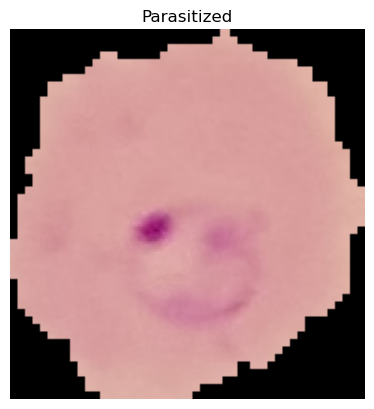

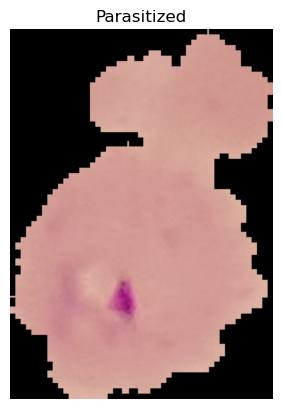

In [3]:
parasitized_images = glob.glob(os.path.join(cell_images_path, "Parasitized", "*.png"))
uninfected_images = glob.glob(os.path.join(cell_images_path, "Uninfected", "*.png"))
print(f"Parasitized images: {len(parasitized_images)}")
print(f"Uninfected images: {len(uninfected_images)}")


for img_path in parasitized_images[:2]:  # Show first 2 images
    image = Image.open(img_path)
    plt.figure()
    plt.imshow(image)
    plt.axis("off")
    plt.title("Parasitized")
    plt.show()  # Explicitly show each image

## Preprocessing
The dataset is of various sizes, so a target size of 128x128 is set. The images will all be resized for this by using Image Preproccesing methods from Keras. The image data is converted to an array and appended to the 'images' array, where a label of 1 (parasitized) or 0 (uninfected) will be simultanously inserted to the 'labels' array, meaning the label and image e.g. at index[2] will be matching. In other words, one-hot encoding the categories.

The pixels of the dataset are also reduced to a size between 0.0 and 1.0, rather than their RGB values of 0-255 to normalize the data. This will allow neural networks often perform better and converge faster.

In [4]:
# Initialize arrays
images = []
labels = []

target_width = 128
target_height = 128

# Load images and assign labels
for img_path in parasitized_images:
    img = load_img(img_path, target_size=(target_width, target_height))  # Resize to (128x128)
    images.append(img_to_array(img))
    labels.append(1)  # Parasitized

for img_path in uninfected_images:
    img = load_img(img_path, target_size=(target_width, target_height))  # Resize to (128x128)
    images.append(img_to_array(img))
    labels.append(0)  # Uninfected

# Convert to numpy arrays
images = np.array(images, dtype="float32") / 255.0  # Normalize pixel values to [0, 1]
labels = np.array(labels)

# Shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


Images shape: (27558, 128, 128, 3)
Labels shape: (27558,)


## Splitting

In [5]:
# Split
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training data: {len(X_train)}")
print(f"Validation data: {len(X_val)}")
print(f"Testing data: {len(X_test)}")


Training data: 19290
Validation data: 4134
Testing data: 4134


## Model Architecture

In [6]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

- Remove ReduceLROnPlateau 
- No Data Augmentation

In [7]:
LEARNING_RATE_PARAM = 0.001

# Learning Rate scheduler
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)

# Optimizers
_rms = keras.optimizers.RMSprop(learning_rate=lr_schedule)
_sgd = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PARAM, momentum=0.9, nesterov=True)
_adam = keras.optimizers.Adam(learning_rate=LEARNING_RATE_PARAM)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

# Batch sizes
_small_batch_size = 16
_default_batch_size = 32 #tf default
_large_batch_size = 64

# Active values
LOSS_PARAM = "binary_crossentropy"  # Only two classes, no "sparse_categorical_crossentropy"
OPTIMIZER_PARAM = _adam
EPOCH_PARAM = 50
BATCH_SIZE = _default_batch_size
CALLBACKS = [early_stopping]
USE_DATAGEN = False

## Model Compilation

In [8]:
model.compile(
    optimizer=OPTIMIZER_PARAM,  # e.g., Adam
    loss=LOSS_PARAM,            # e.g., 'binary_crossentropy'
    metrics=['accuracy']        # Metrics to track
)

## Data Augmentation

In [9]:
# Optional
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
)

train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

## Training the model

In [10]:
print(f"Using batch size: {BATCH_SIZE}")
print(f"Using learning rate: {LEARNING_RATE_PARAM}")
print(f"Using optimizer: {OPTIMIZER_PARAM}")
print(f"Using loss: {LOSS_PARAM}")
print(f"Epoch size: {EPOCH_PARAM}")
print(f"Using data augmentation: {USE_DATAGEN}")

if (USE_DATAGEN):
    history = model.fit(
        train_generator,
        validation_data=(X_val, y_val),
        epochs=EPOCH_PARAM,
        # Omit batch size when using data augmentation.
        callbacks=CALLBACKS
    )
else:
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCH_PARAM,
        batch_size=BATCH_SIZE,
        callbacks=CALLBACKS
    )

Using batch size: 32
Using learning rate: 0.001
Using optimizer: <keras.src.optimizers.adam.Adam object at 0x0000014C0EAE18B0>
Using loss: binary_crossentropy
Epoch size: 50
Using data augmentation: False
Epoch 1/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.7051 - loss: 0.5220 - val_accuracy: 0.9359 - val_loss: 0.1774
Epoch 2/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.9407 - loss: 0.1722 - val_accuracy: 0.9485 - val_loss: 0.1522
Epoch 3/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - accuracy: 0.9536 - loss: 0.1395 - val_accuracy: 0.9528 - val_loss: 0.1539
Epoch 4/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 39s 64ms/step - accuracy: 0.9619 - loss: 0.1112 - val_accuracy: 0.9560 - val_loss: 0.1531
Epoch 5/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - accuracy: 0.9695 - loss: 0.0871 - val_accuracy: 0.9548 - val_loss: 0.1614
Epoch 6/50
603/603 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - accuracy: 0.9791 - loss: 0.0608 - val_accuracy: 0.9526 - val_loss: 0.1943
Epoch 7/50
603/

## Inspect the learning curve

In [11]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

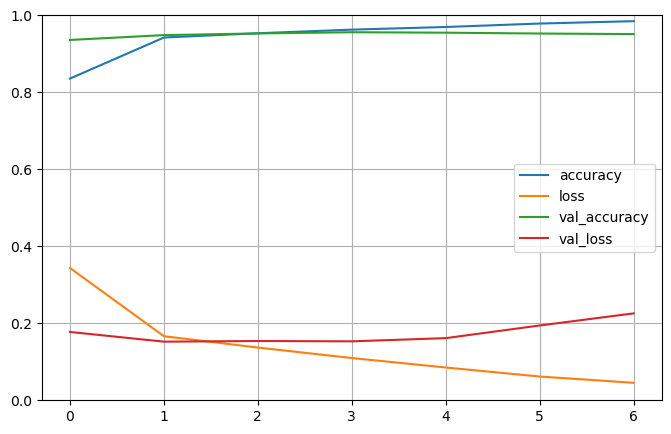

In [12]:
# Show the learning curves.
# (The training curves should be shifted half an epoch to the left to be completely comparable with
# the validation curves).

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Model evaluation

In [13]:
model.evaluate(X_test, y_test)

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9620 - loss: 0.1336


[0.1476401835680008, 0.9547653794288635]